I've specified a plot_style document that can be loaded with: plt.style.use('/data/notebooks/jupyterlab-biascorrlab/plot_style.txt')

We have 3 different types of dataset (they all have different dimension sizes and so can't really be combined).

The output from our BG fit (a.k.a. observations used for GP fit) is plot using a scatter diagram where the size of the markers needs to be adjusted relative to the density of points and the figure size. It is suggested that this is defined for each plot.

The conditioned data is plot using contourf since technically our GP is defined over a continuous space. When we apply the change of support onto a grid we can represent the data using a pcolormesh. 

The BG fit to all grid cells data is plot using a pcolormesh, which represents the support of the climate model. 

Note upon researching plotting I noticed that the font size doesn't depend on figure size, however when you change the DPI this scales everything in the figure including the fonts. So the best approach is to specify the DPI and font sizes in a plot_style.txt file which works well with a single column and double column figure size and then the height can be adjusted for each plot depending on the number of rows.

Additional things that need doing:
- The standard deviation in the predictions is the same for p and loc, this is an error in the code that I believe I've corrected but haven't got round to propagating all the way through to results, which needs doing
- It would be good to write some descriptive text under each plot
- Uncertainty needs calculating in the proper way, where we take lots of realisations of the GPs parameters and predictions and then build up our posterior predictive from that.

In [1]:
%load_ext lab_black
# %load_ext autoreload
# %autoreload 2

# This is a notebook for examining the output of the gp_lima_tinygp.py script. 

In [2]:
import arviz as az
import numpy as np
import xarray as xr
import geopandas
import cartopy.crs as ccrs

import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

base_path = '/home/jez/Bias_Correction/'
plt.style.use(f"{base_path}plot_style.txt")

cm = 1 / 2.54  # centimeters in inches
sc = 7.9 * cm  # single_column
dc = 18.2 * cm  # double_column

from src.helper_functions import unstandardise
from src.helper_functions import grid_coords_to_2d_latlon_coords
from src.helper_functions import build_gp
from src.helper_functions import standardise


In [3]:
# Loading GP inference data
gp_idata_path = f"{base_path}data/Lima2021/NST_GPFit.nc"
gp_idata = az.from_netcdf(gp_idata_path)

In [4]:
az.summary(gp_idata)

arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
loc_kern_var,3.601,0.802,2.150,5.125,0.025,0.018,1045.0,1203.0,NaN
loc_lengthscale,0.057,0.029,0.010,0.107,0.001,0.001,1202.0,572.0,NaN
loc_like_var,2.990,0.839,1.427,4.551,0.028,0.020,902.0,747.0,NaN
loc_mean,-7.492,0.376,-8.219,-6.814,0.010,0.007,1472.0,1305.0,NaN
scale_kern_var,0.222,0.179,0.001,0.530,0.005,0.004,889.0,641.0,NaN
scale_lengthscale,1.007,0.672,0.001,2.190,0.023,0.016,648.0,440.0,NaN
scale_like_var,0.247,0.078,0.104,0.395,0.002,0.002,972.0,533.0,NaN
scale_mean,2.908,0.219,2.474,3.330,0.007,0.005,1040.0,823.0,NaN


In [ ]:
#FIXME: The lengthscale for loc is dubiously small - this is either a result of the data or the code. Need to talk to Erick about this.

## Examining Posterior

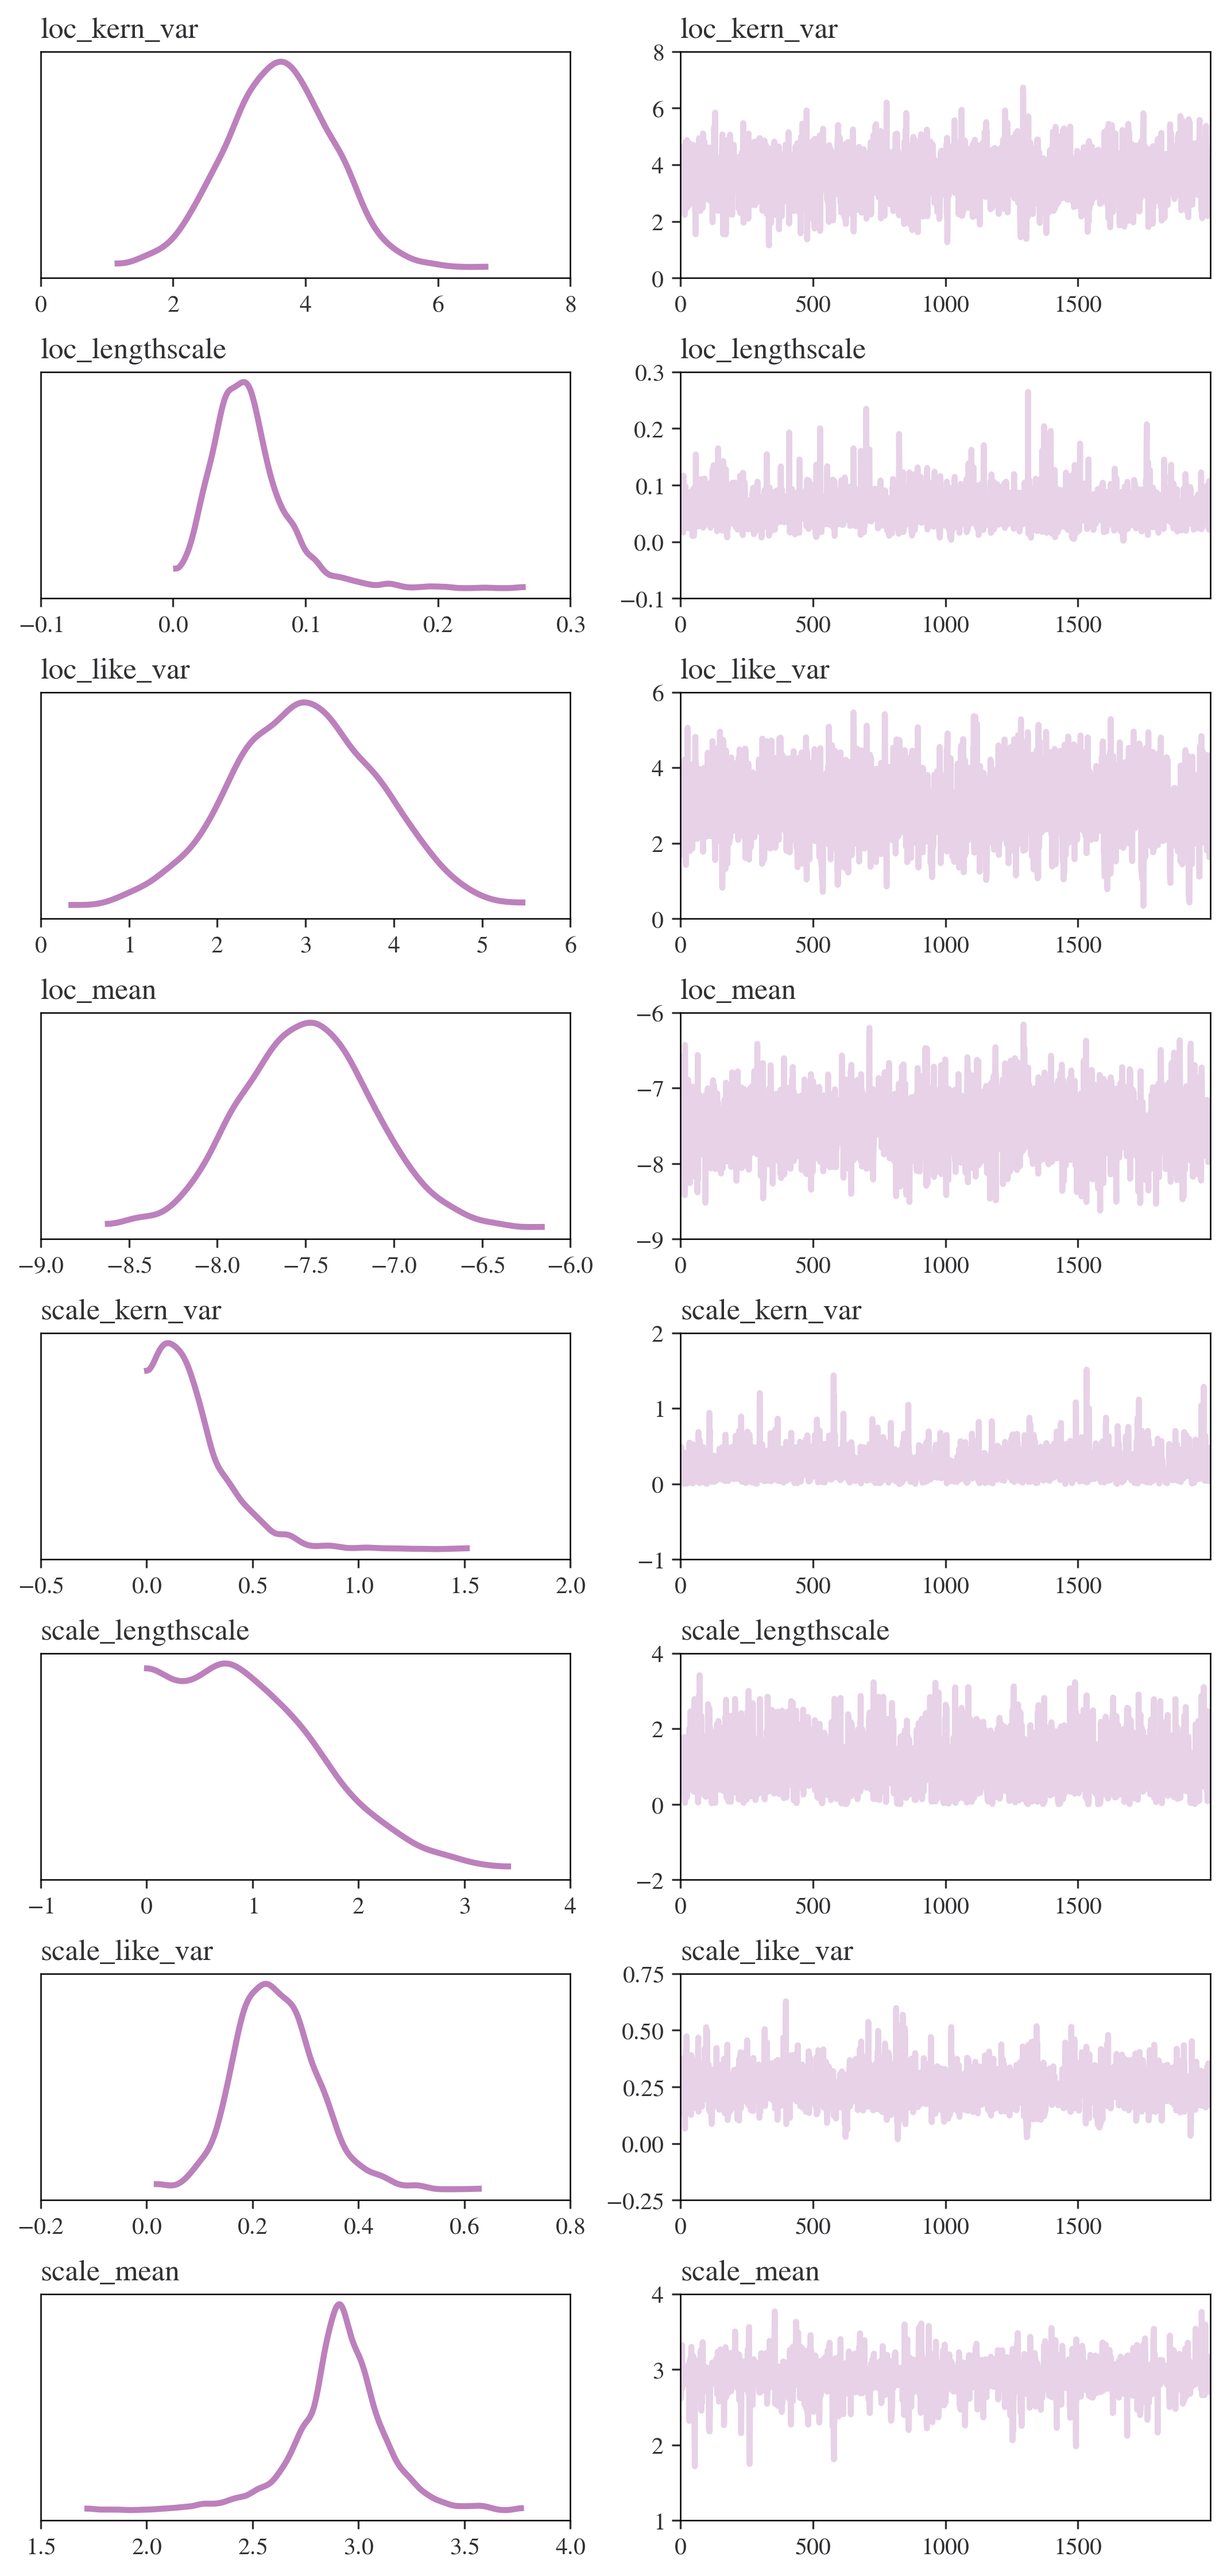

In [4]:
az.plot_trace(gp_idata, compact=True, figsize=(dc, 15))
plt.tight_layout()

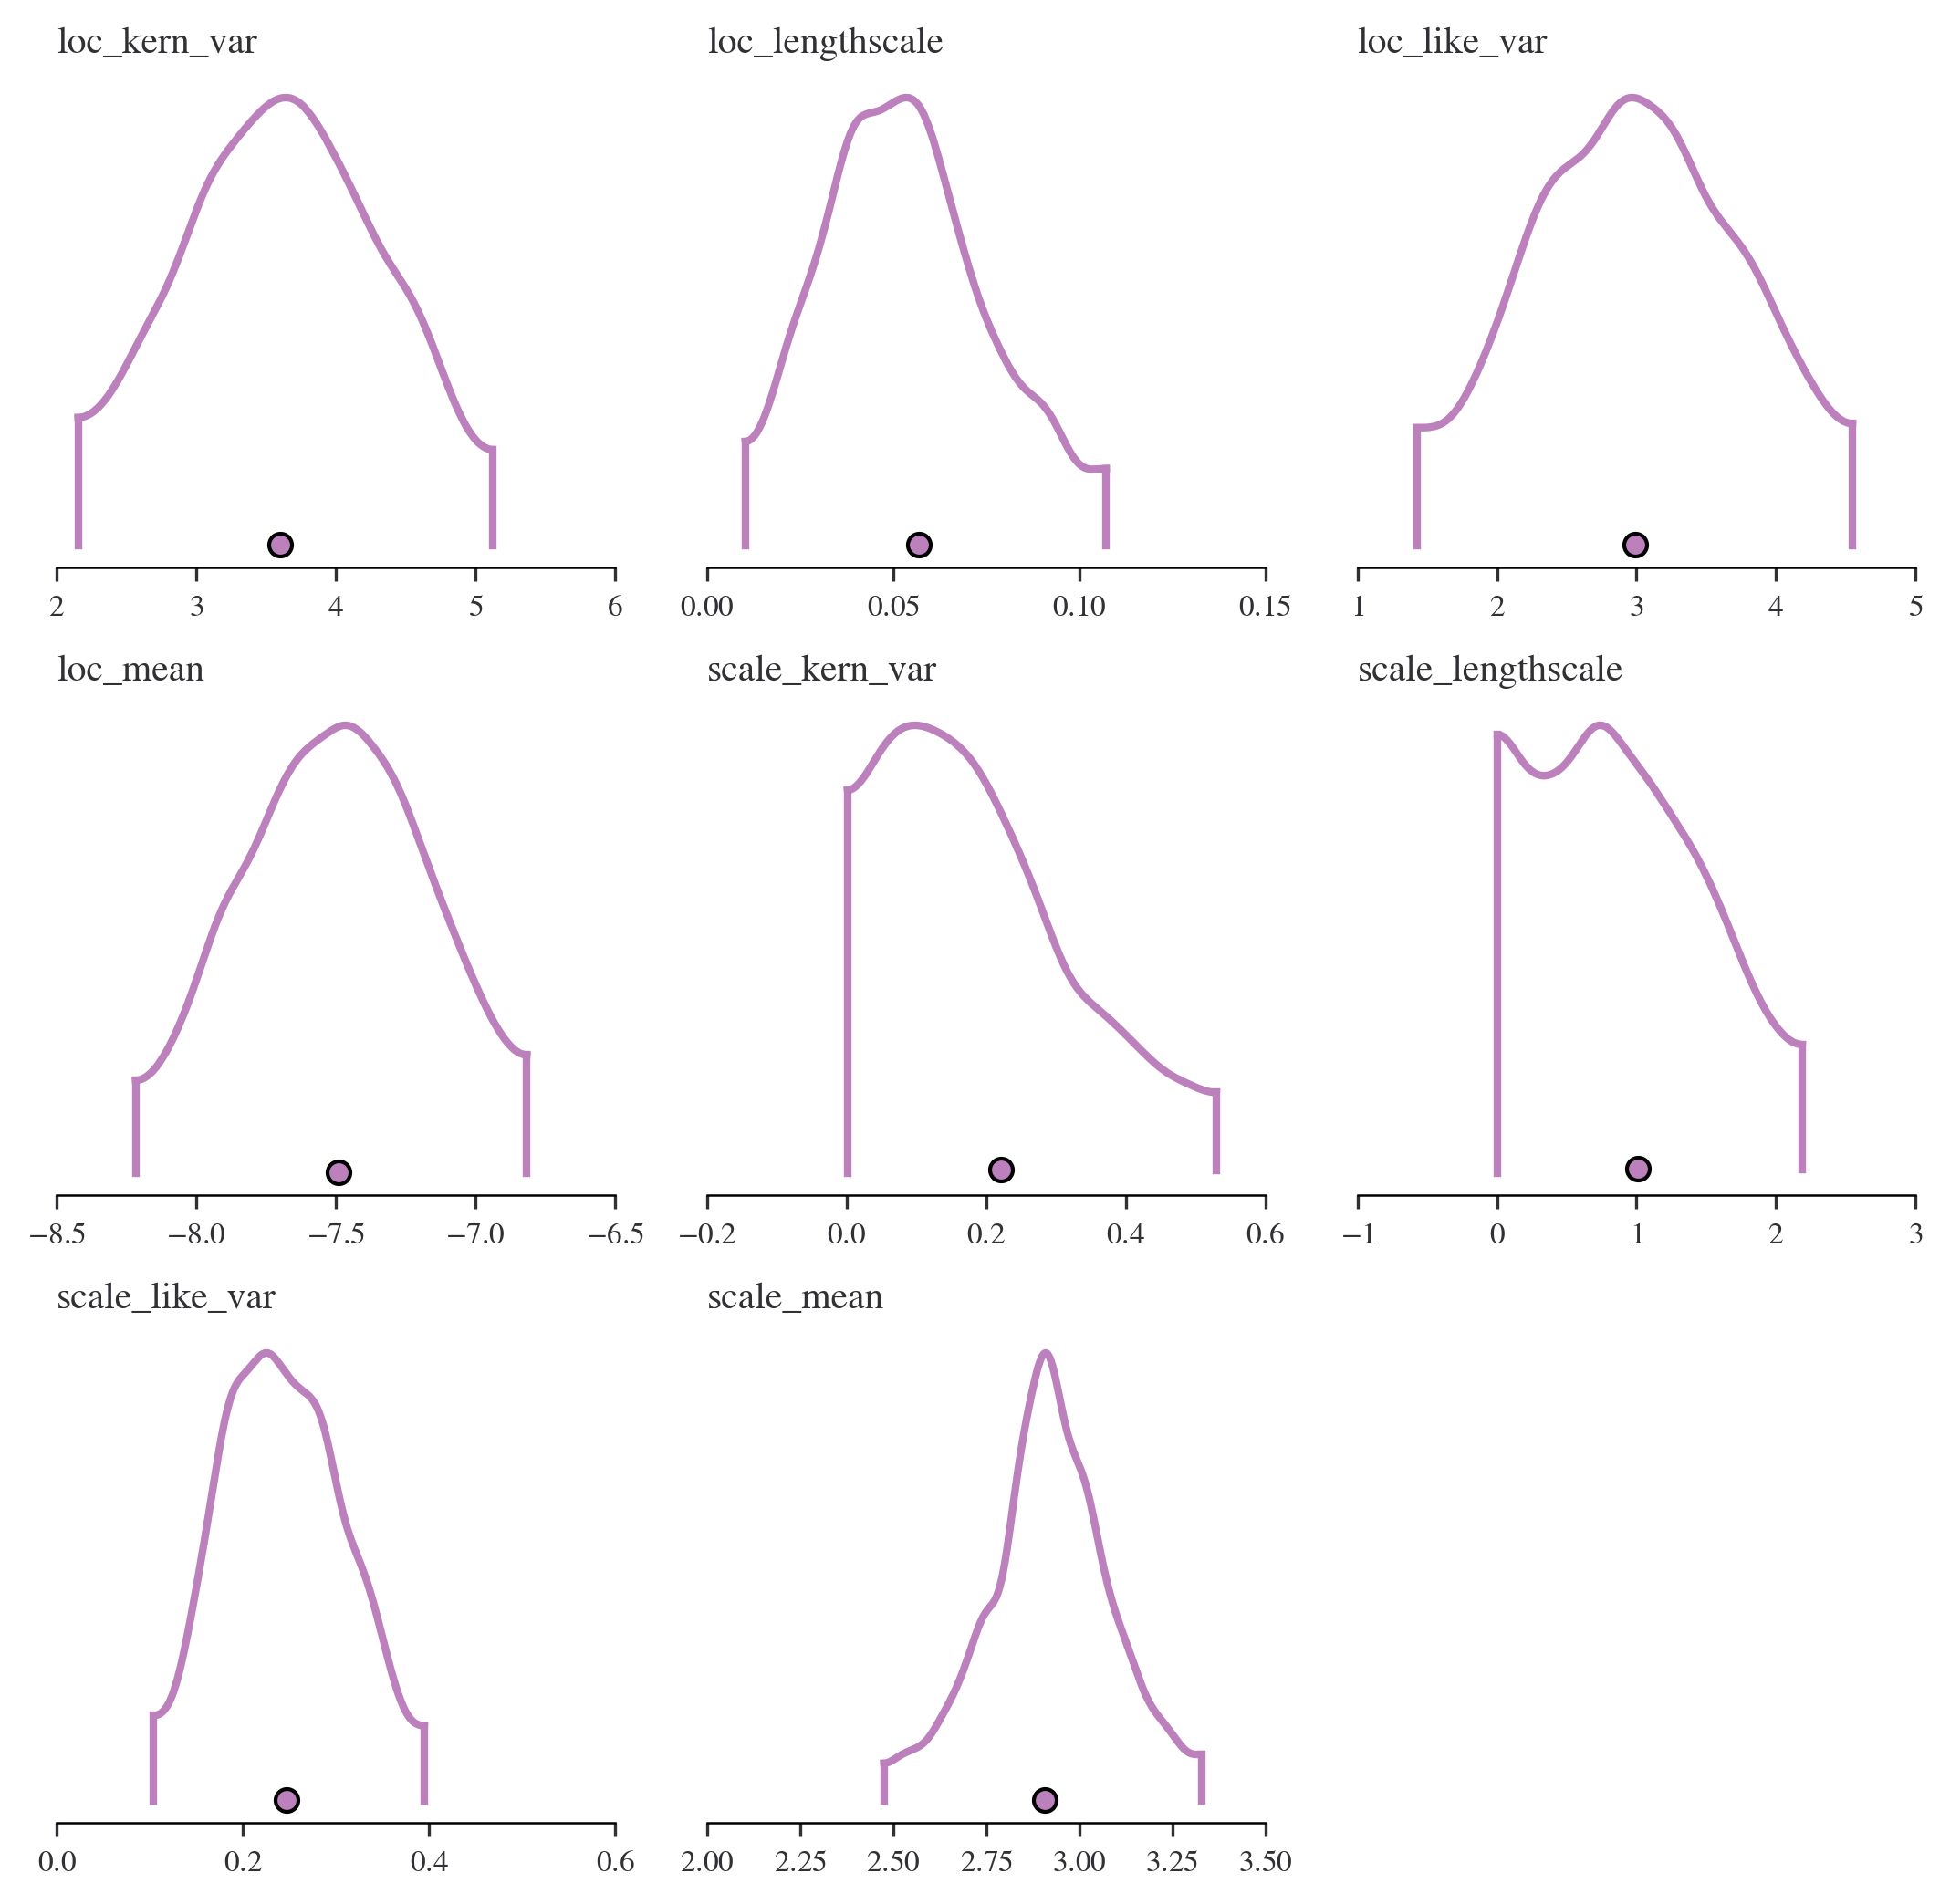

In [5]:
az.plot_density(gp_idata, figsize=(dc, 7))
plt.tight_layout()
plt.show()

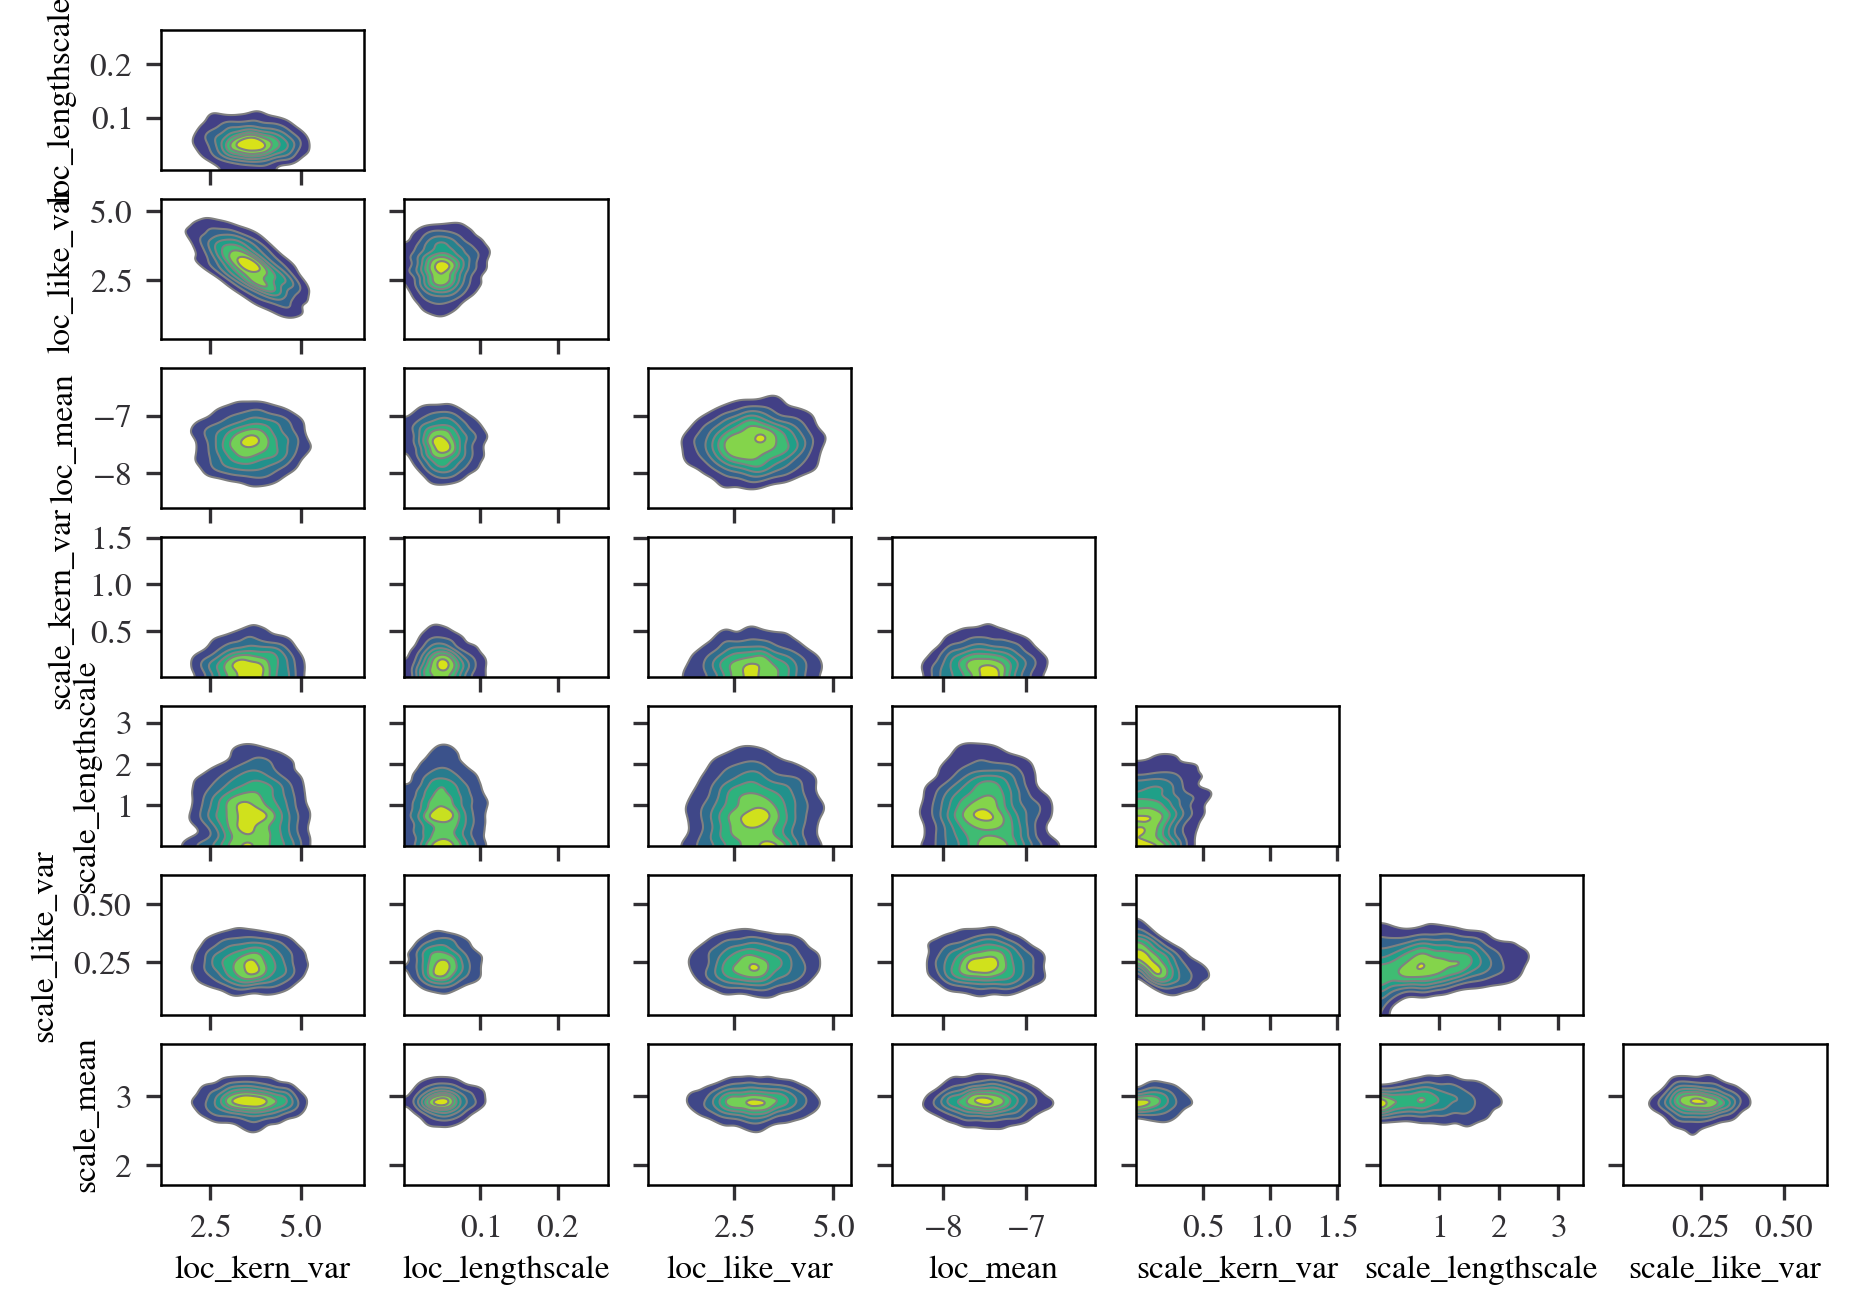

In [6]:
with plt.rc_context({"lines.linewidth": 0.5}):
    az.plot_pair(gp_idata, figsize=(dc, 5), kind="kde")
plt.show()

## Conditioning on New Grid (Posterior Predictive)

In [5]:
# Defining new grid to make predictions over
"""coordinates are in standardised units equivalent to the grid_lat_standardised and grid_lon_standardised coordinates used to fit the GP in gp_lima_tinygp.py"""
x_new = np.arange(-3, 3, 0.1)
x_new_grid = np.meshgrid(x_new, x_new)
X_new = np.array(x_new_grid).reshape((2, -1)).T

In [6]:
# Constructing the GP objects from the inference data
loc_gp = build_gp(gp_idata, "loc")
scale_gp = build_gp(gp_idata, "scale")
# Conditioning based on observed data and on new coordinates
_, loc_gpcond = loc_gp.condition(gp_idata.observed_data["loc"].data, X_new)
_, scale_gpcond = scale_gp.condition(gp_idata.observed_data["scale"].data, X_new)

In [7]:
# Getting the mean and standard deviation of predictions
loc_mean, loc_std = loc_gpcond.mean, np.sqrt(loc_gpcond.variance)
scale_mean, scale_std = scale_gpcond.mean, np.sqrt(scale_gpcond.variance)

In [8]:
# Placing results into xarray dataset
ds = xr.Dataset(
    data_vars=dict(
        loc=(
            ["grid_latitude", "grid_longitude", "metric"],
            np.dstack(
                [
                    loc_mean.reshape((len(x_new), -1)),
                    loc_std.reshape((len(x_new), -1)),
                ]
            ),
        ),
        scale=(
            ["grid_latitude", "grid_longitude", "metric"],
            np.dstack(
                [scale_mean.reshape((len(x_new), -1)), scale_std.reshape((len(x_new), -1))]
            ),
        ),
    ),
    coords=dict(
        grid_longitude_standardised=("grid_longitude", x_new),
        grid_latitude_standardised=("grid_latitude", x_new),
        grid_longitude=(
            "grid_longitude",
            unstandardise(
                newdata=x_new, refdata=gp_idata.observed_data.grid_longitude.data
            ),
        ),
        grid_latitude=(
            "grid_latitude",
            unstandardise(
                newdata=x_new, refdata=gp_idata.observed_data.grid_latitude.data
            ),
        ),
        metric=("metric", ["mean", "std"]),
    ),
)
# Calculating actual Latitude/Longitude values at new locations and appending to dataset
ds = grid_coords_to_2d_latlon_coords(
    ds,
    f"{base_path}data/AP_Daily_Snowfall_044.nc",
)

## Loading Bernoulli-Gamma fit to all grid cells in domain independently

In [9]:
# Loading BG fit to all grid cells
bg_all_idata_path = f"/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/AP_Daily_Snowfall_All_Observations_BG_Fit.nc"
bg_all_idata = az.from_netcdf(bg_all_idata_path)

FileNotFoundError: [Errno 2] No such file or directory: b'/data/notebooks/jupyterlab-biascorrlab/data/Lima2021/AP_Daily_Snowfall_All_Observations_BG_Fit.nc'

In [9]:
# Adjusting the dimensions to go from sites (1050) back to grid_latitude (30) & grid_longitude (35) - reversing process in simulating_observations.py
base_path = "/data/notebooks/jupyterlab-biascorrlab/data/"
path = f"{base_path}ProcessedData/AP_Daily_Snowfall_044.nc"
original_ds = xr.open_dataset(path)
original_ds_stacked = original_ds.stack(sites=["grid_latitude", "grid_longitude"])

bg_all = bg_all_idata.posterior.copy()
bg_all = bg_all.drop_vars(["grid_latitude", "grid_longitude"])
bg_all = bg_all.assign(sites=original_ds_stacked.get_index("sites"))
bg_all = bg_all.unstack()

In [10]:
# Adjusting the grid-latitude_standardised and grid_longitude_standardised coordinates such that they align with the standardisation used on the land_only_100 observations dataset
base_path = "/data/notebooks/jupyterlab-biascorrlab/data/"
ref_path = f"{base_path}ProcessedData/AP_Daily_Snowfall_Land_Only_Distributed_Observations_100_Reformatted.nc"
ref_ds = xr.open_dataset(ref_path)

# Create new standardised grid_latitude and grid_longitude coordinates
grid_latitude_standardised = standardise(bg_all.grid_latitude, ref_ds.grid_latitude)
grid_longitude_standardised = standardise(bg_all.grid_longitude, ref_ds.grid_longitude)
bg_all = bg_all.assign_coords(
    grid_latitude_standardised=("grid_latitude", grid_latitude_standardised.data),
    grid_longitude_standardised=("grid_longitude", grid_longitude_standardised.data),
)

## Plotting Mean and Standard Deviation of Predictions against Observations on Standardised Grid

In [10]:
gp_idata.observed_data

<xarray.Dataset>
Dimensions:                      (sites: 56)
Coordinates:
  * sites                        (sites) int64 0 1 2 3 4 5 ... 50 51 52 53 54 55
    grid_latitude                (sites) float64 4.229 6.765 ... 5.423 5.341
    grid_longitude               (sites) float64 -10.69 -11.98 ... -11.39 -11.58
    latitude                     (sites) float64 ...
    longitude                    (sites) float64 ...
    grid_latitude_standardised   (sites) float64 0.2605 1.109 ... 0.6598 0.6326
    grid_longitude_standardised  (sites) float64 -0.2969 -0.8644 ... -0.6918
Data variables:
    loc                          (sites) float64 -6.54 -3.103 ... -5.366 -5.041
    scale                        (sites) float64 2.829 2.183 ... 2.859 3.003
Attributes:
    created_at:                 2022-11-08T15:47:10.530019
    arviz_version:              0.13.0
    inference_library:          numpyro
    inference_library_version:  0.10.1

In [15]:
ref_ds = gp_idata.observed_data

antarctica_gdf = geopandas.read_file(
    f"{base_path}data/Antarctica_Shapefile/antarctica_shapefile.shp"
)

rotated_coord_system = ccrs.RotatedGeodetic(
    13.079999923706055,
    0.5199999809265137,
    central_rotated_longitude=180.0,
    globe=None,
)

antarctica_gdf = antarctica_gdf.to_crs(rotated_coord_system)
# antarctica_gdf = antarctica_gdf.translate(180, 0)

standardised_antarctica_gdf = antarctica_gdf.translate(
    -ref_ds.grid_latitude.mean(), -ref_ds.grid_longitude.mean()
)
standardised_antarctica_gdf = standardised_antarctica_gdf.scale(
    1 / ref_ds.grid_latitude.std(), 1 / ref_ds.grid_longitude.std(), origin=(0, 0)
)

ERROR:fiona._env:PROJ: proj_identify: /home/jez/anaconda3/share/proj/proj.db lacks DATABASE.LAYOUT.VERSION.MAJOR / DATABASE.LAYOUT.VERSION.MINOR metadata. It comes from another PROJ installation.


<AxesSubplot: >

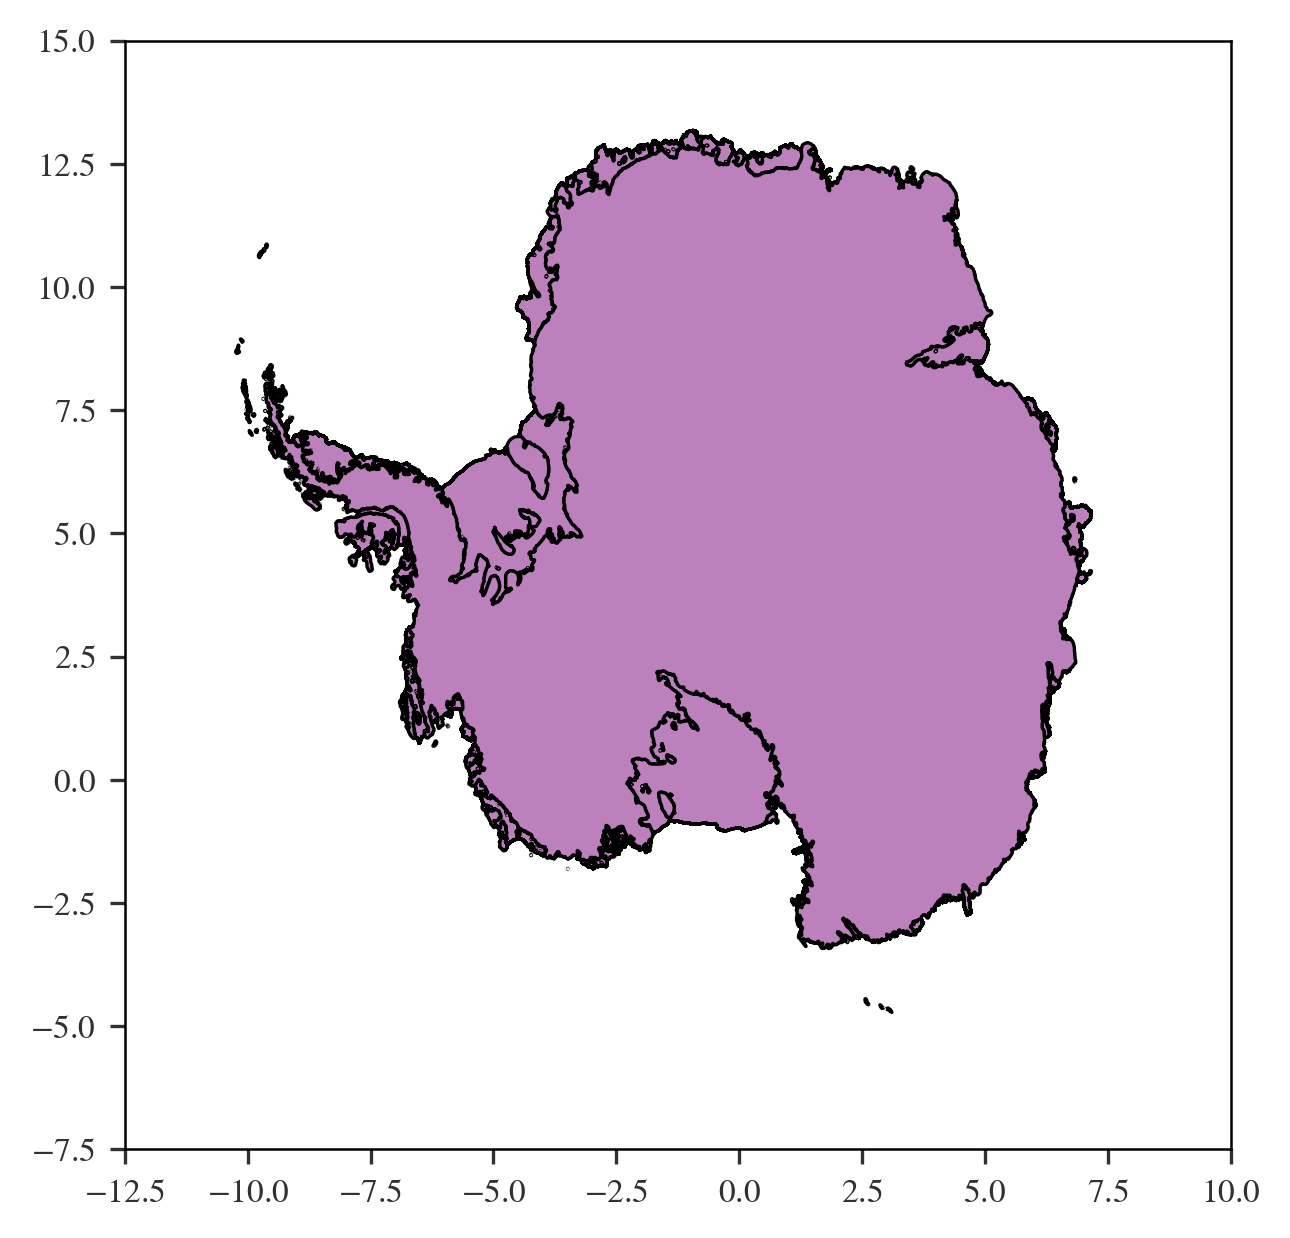

In [16]:
standardised_antarctica_gdf.plot()

In [ ]:
# Possible option for defining limits on axes
# min_grid_longitude_standardised, max_grid_longitude_standardised = (
#     gp_idata.observed_data.grid_longitude_standardised.min(),
#     gp_idata.observed_data.grid_longitude_standardised.max(),
# )
# min_grid_latitude_standardised, max_grid_latitude_standardised = (
#     gp_idata.observed_data.grid_latitude_standardised.min(),
#     gp_idata.observed_data.grid_latitude_standardised.max(),
# )

AxesSubplot(0.125,0.53;0.352273x0.35)
AxesSubplot(0.547727,0.53;0.352273x0.35)
AxesSubplot(0.125,0.11;0.352273x0.35)
AxesSubplot(0.547727,0.11;0.352273x0.35)


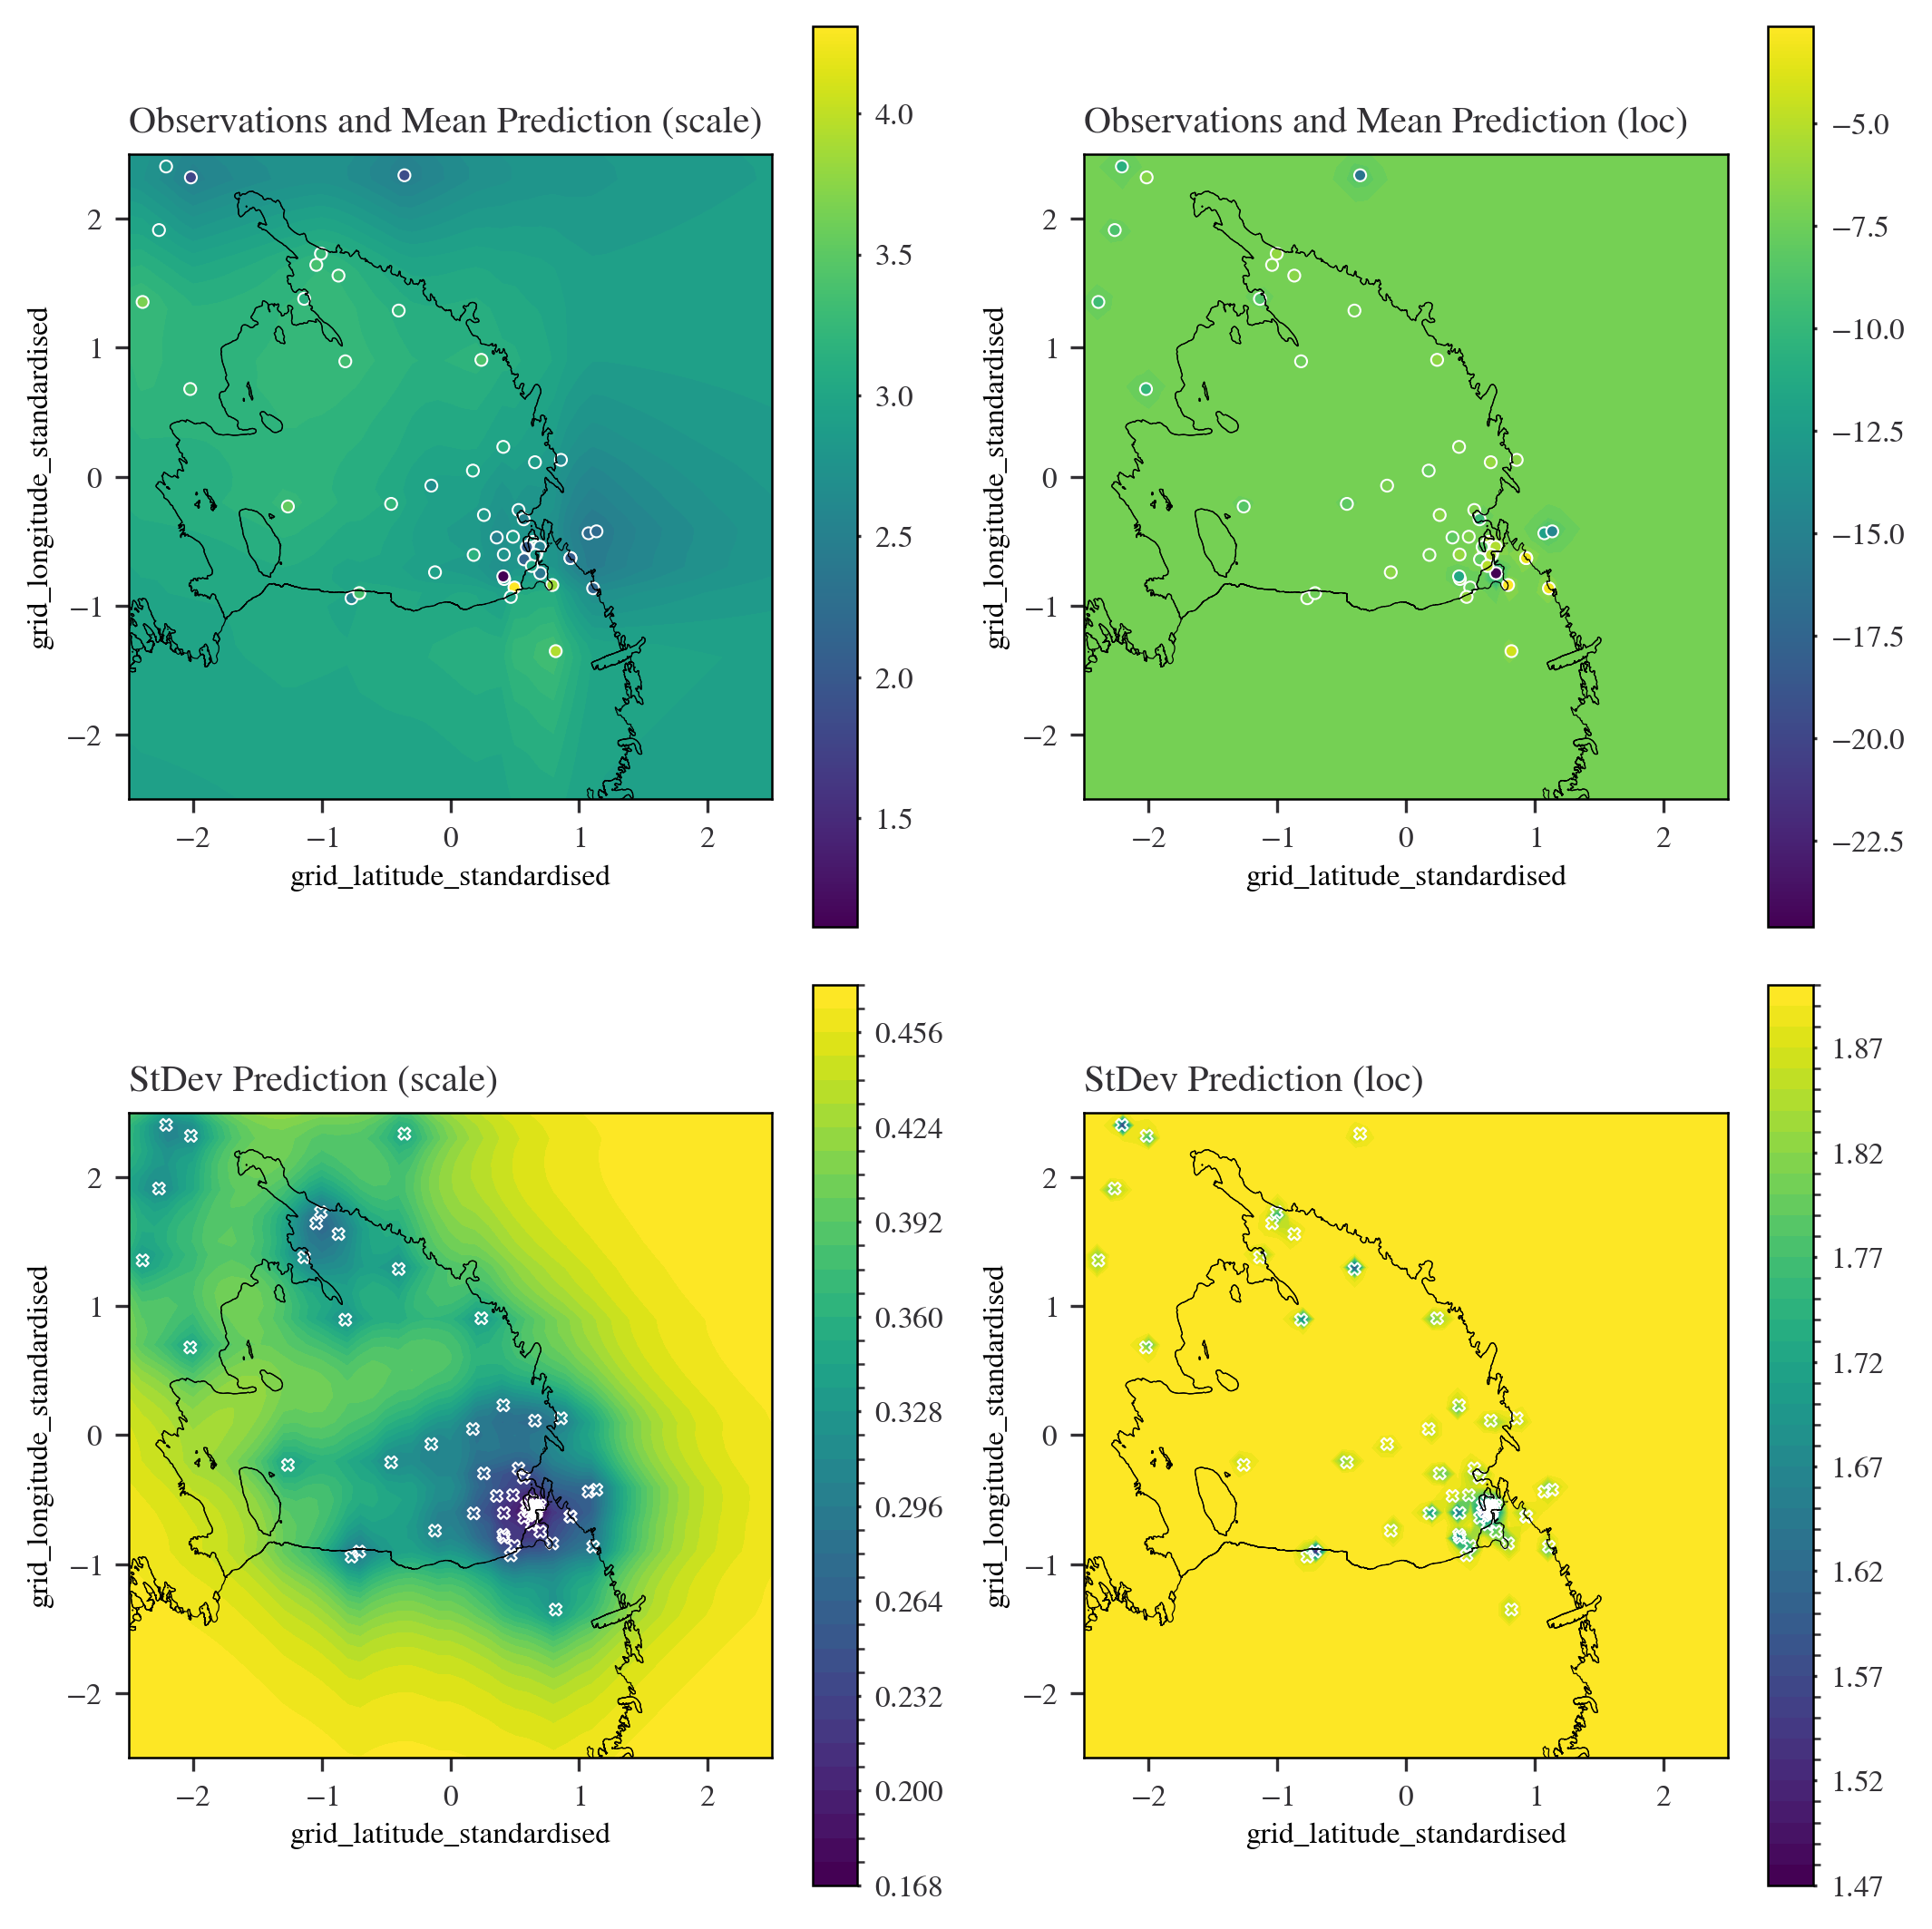

In [19]:
min_grid_longitude_standardised, max_grid_longitude_standardised = -2.5, 2.5
min_grid_latitude_standardised, max_grid_latitude_standardised = -2.5, 2.5

min_scale, max_scale = gp_idata.observed_data.scale.min(), gp_idata.observed_data.scale.max()
min_loc, max_loc = (
    gp_idata.observed_data['loc'].min(),
    gp_idata.observed_data['loc'].max(),
)
limits = {"scale": [min_scale, max_scale], "loc": [min_loc, max_loc]}

marker_linewidth = 0.5  # linewidth for scatter plot markers
marker_size = 10  # size for scatter plot markers

columns = 2
rows = 2
fig, axs = plt.subplots(2, 2, figsize=(dc, dc))
plots = []
variables = ["scale", "loc"]

# 'Observations' used and predictions from GP
for i, var in zip(range(1, 3), variables):
    plt.subplot(rows, columns, i)
    plots.append(
        gp_idata.observed_data.plot.scatter(
            x="grid_latitude_standardised",
            y="grid_longitude_standardised",
            hue=f"{var}",
            s=marker_size,
            linewidths=marker_linewidth,
            vmin=limits[f"{var}"][0],
            vmax=limits[f"{var}"][1],
            add_colorbar=False,
        )
    )
    ds.sel(metric="mean")[f"{var}"].plot.contourf(
        x="grid_latitude_standardised",
        y="grid_longitude_standardised",
        vmin=limits[f"{var}"][0],
        vmax=limits[f"{var}"][1],
        levels=50,
        add_colorbar=False,
        zorder=-1,
    )
    plt.title(f"Observations and Mean Prediction ({var})")

# Observation locations and Standard deviation in predictions from GP
for i, var in zip(range(3, 5), variables):
    plt.subplot(rows, columns, i)
    plots.append(
        ds.sel(metric="std")[f"{var}"].plot.contourf(
            x="grid_latitude_standardised",
            y="grid_longitude_standardised",
            levels=50,
            add_colorbar=False,
            zorder=-1,
        )
    )
    gp_idata.observed_data.plot.scatter(
        x="grid_latitude_standardised",
        y="grid_longitude_standardised",
        facecolors="none",
        marker="X",
        s=marker_size,
        linewidths=marker_linewidth,
        vmin=limits[f"{var}"][0],
        vmax=limits[f"{var}"][1],
        add_colorbar=False,
    )
    plt.title(f"StDev Prediction ({var})")

# Adjusting axes limits and creating colorbars that can be customised
for plot, ax in zip(plots, axs.ravel()):
    print(ax)
    ax.set_xlim([min_grid_longitude_standardised, max_grid_longitude_standardised])
    ax.set_ylim([min_grid_latitude_standardised, max_grid_latitude_standardised])

    cbar = fig.colorbar(plot, ax=ax)
    cbar.ax.tick_params(size=1)

    standardised_antarctica_gdf.boundary.plot(ax=ax, color="k", linewidth=0.3)

plt.tight_layout()

### Plotting Mean of Predictions against Observations on Latitude-Longitude Grid with Coastlines Marked

/data/conda/bc/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/data/conda/bc/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/data/conda/bc/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/data/conda/bc/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__

< GeoAxes: +proj=ortho +a=6378137.0 +lon_0=0.0 +lat_0=-90.0 +no_defs +type=crs >
< GeoAxes: +proj=ortho +a=6378137.0 +lon_0=0.0 +lat_0=-90.0 +no_defs +type=crs >
< GeoAxes: +proj=ortho +a=6378137.0 +lon_0=0.0 +lat_0=-90.0 +no_defs +type=crs >
< GeoAxes: +proj=ortho +a=6378137.0 +lon_0=0.0 +lat_0=-90.0 +no_defs +type=crs >
< GeoAxes: +proj=ortho +a=6378137.0 +lon_0=0.0 +lat_0=-90.0 +no_defs +type=crs >
< GeoAxes: +proj=ortho +a=6378137.0 +lon_0=0.0 +lat_0=-90.0 +no_defs +type=crs >


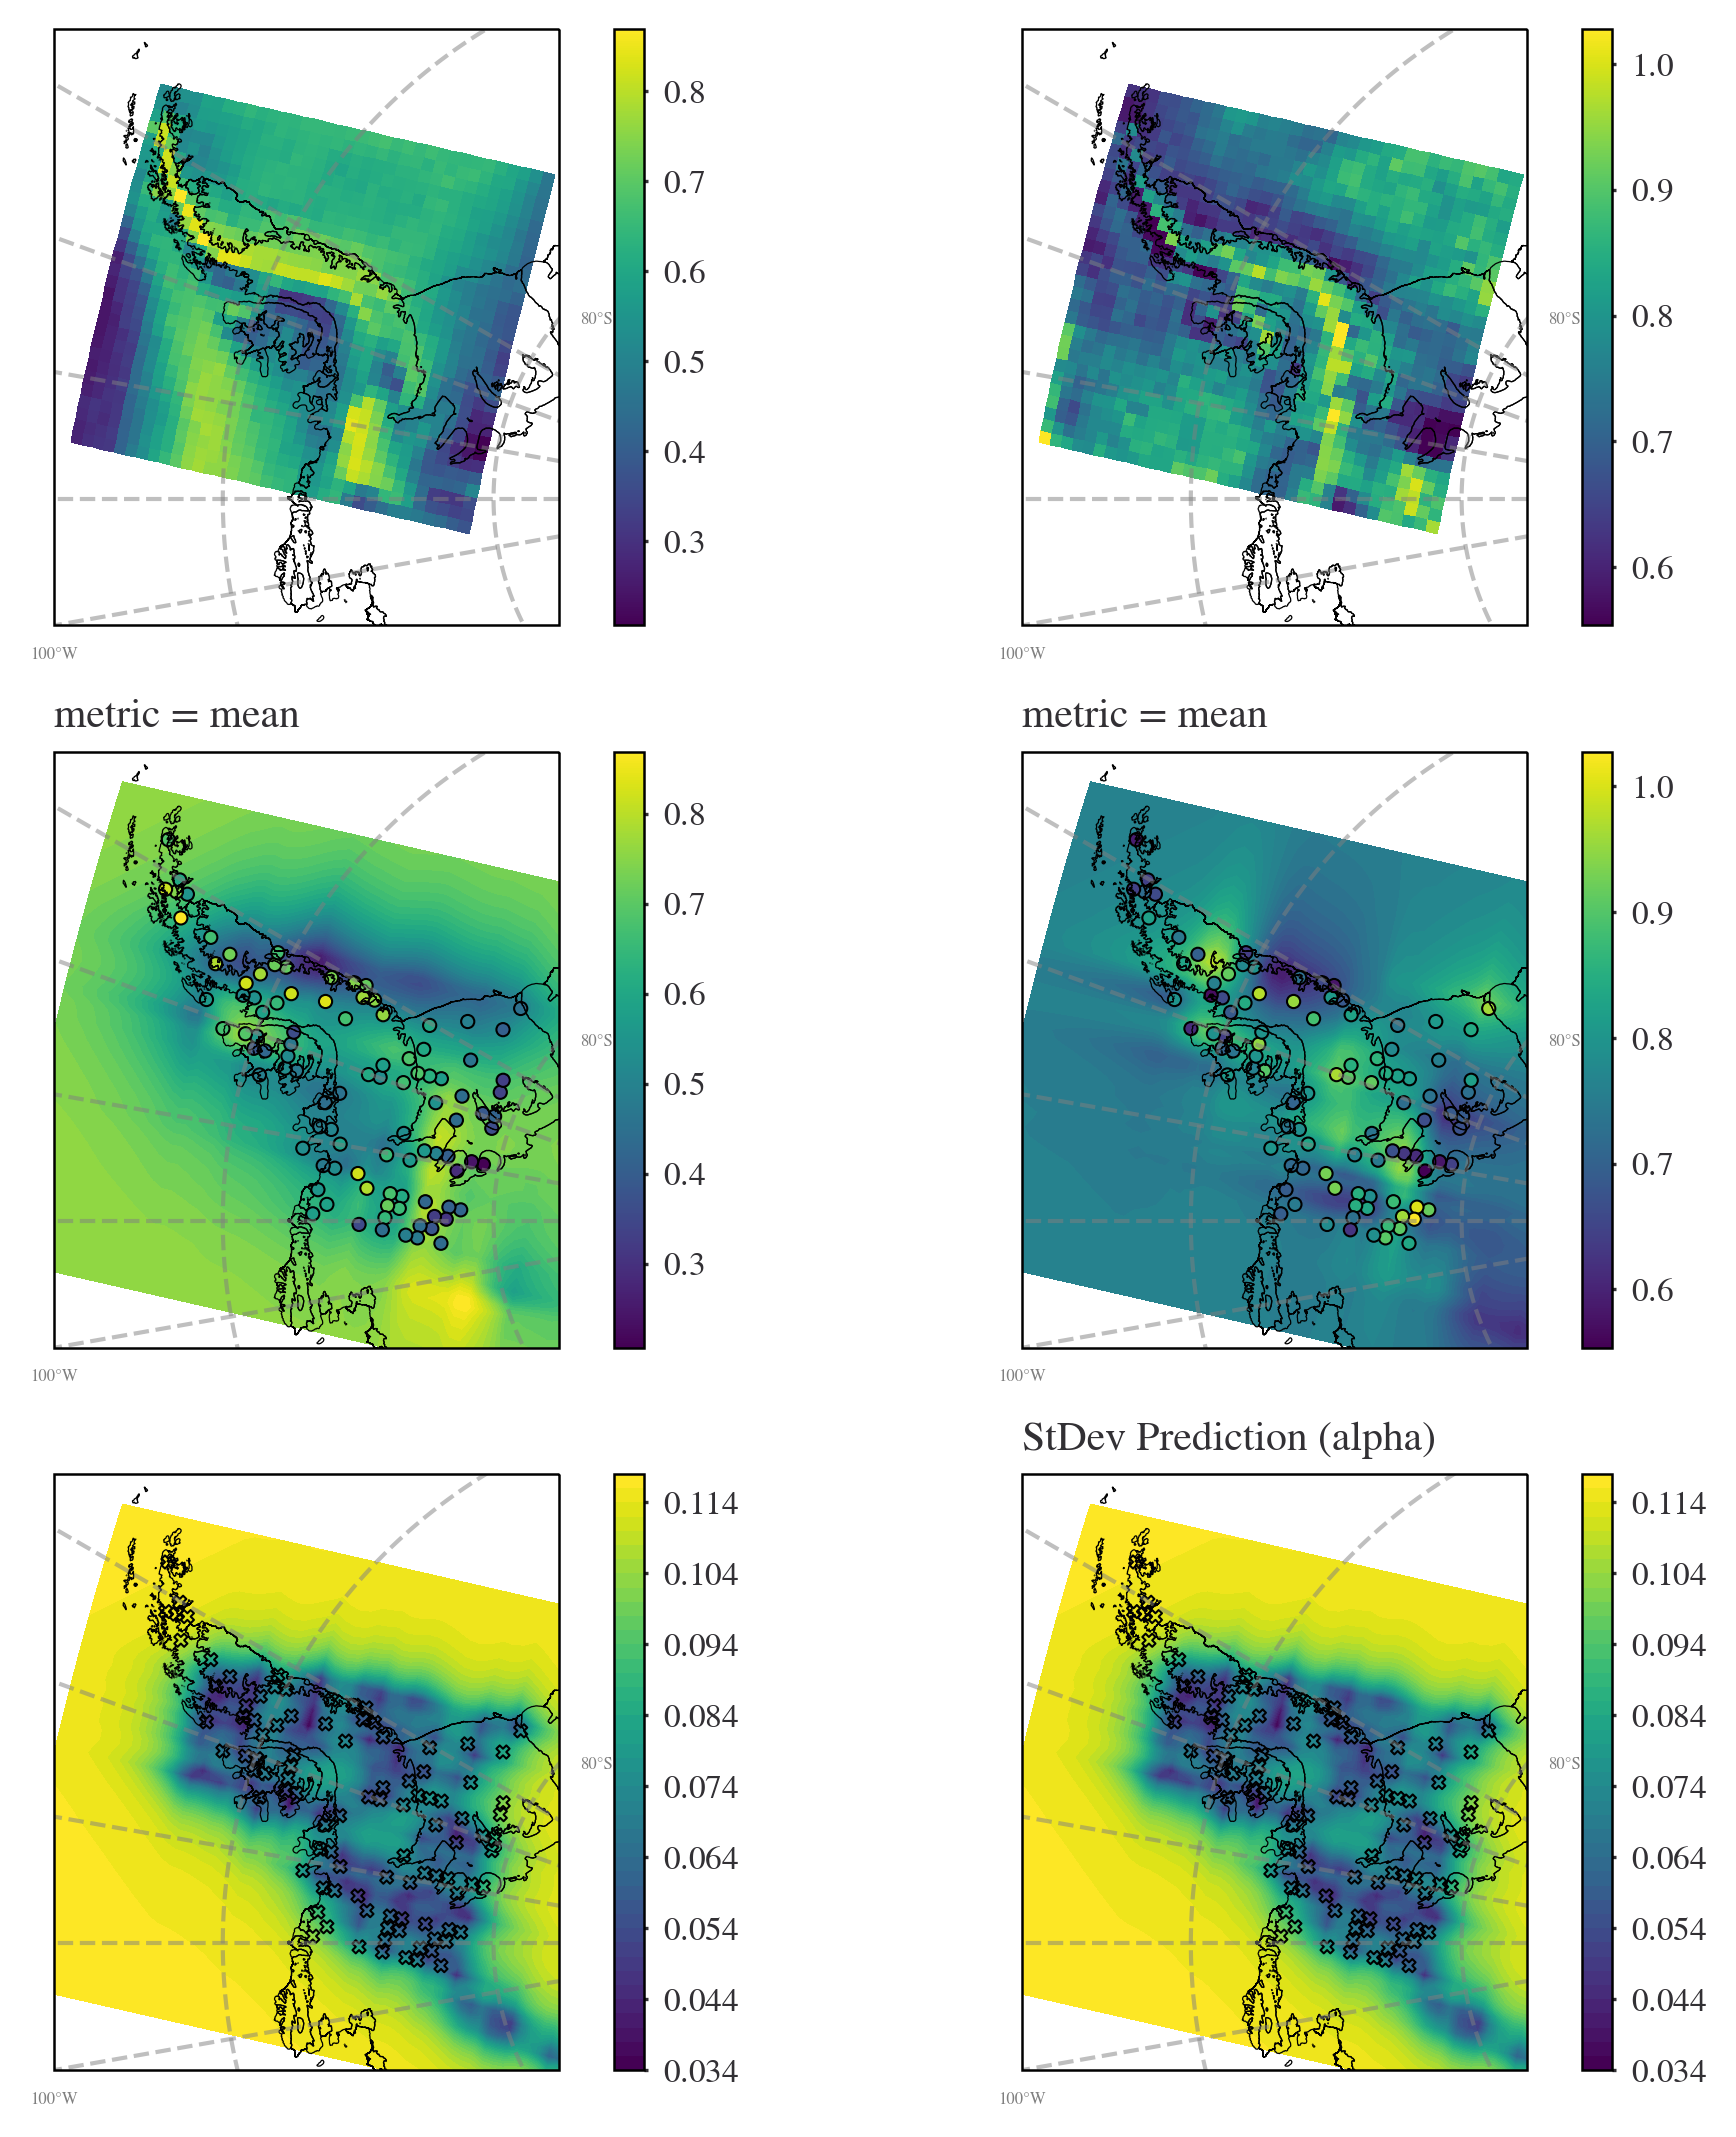

In [38]:
map_proj = ccrs.Orthographic(central_longitude=0.0, central_latitude=-90.0, globe=None)

min_p, max_p = gp_idata.observed_data.p.min(), gp_idata.observed_data.p.max()
min_alpha, max_alpha = (
    gp_idata.observed_data.alpha.min(),
    gp_idata.observed_data.alpha.max(),
)
limits = {"p": [min_p, max_p], "alpha": [min_alpha, max_alpha]}

marker_linewidth = 0.5  # linewidth for scatter plot markers
marker_size = 10  # size for scatter plot markers

columns = 2
rows = 3
fig, axs = plt.subplots(3, 2, subplot_kw={"projection": map_proj}, figsize=(dc, dc))
plots = []
variables = ["p", "alpha"]

# 'Truth' Values to Compare Against
for i, var in zip([0, 1], variables):
    plots.append(
        bg_all.mean(["chain", "draw", "months"])[f"{var}"].plot.pcolormesh(
            x="longitude",
            y="latitude",
            vmin=limits[f"{var}"][0],
            vmax=limits[f"{var}"][1],
            add_colorbar=False,
            zorder=-1,
            transform=ccrs.PlateCarree(),
            ax=axs[0, i],
        )
    )
    plt.title(f"Truth ({var})")

# 'Observations' used and predictions from GP
for i, var in zip([0, 1], variables):
    plots.append(
        gp_idata.observed_data.plot.scatter(
            x="longitude",
            y="latitude",
            hue=f"{var}",
            s=marker_size,
            linewidths=marker_linewidth,
            vmin=limits[f"{var}"][0],
            vmax=limits[f"{var}"][1],
            add_guide=False,
            transform=ccrs.PlateCarree(),
            ax=axs[1, i],
        )
    )
    ds.sel(metric="mean")[f"{var}"].plot.contourf(
        x="longitude",
        y="latitude",
        vmin=limits[f"{var}"][0],
        vmax=limits[f"{var}"][1],
        levels=50,
        add_colorbar=False,
        zorder=-1,
        transform=ccrs.PlateCarree(),
        ax=axs[1, i],
    )
    plt.title(f"Observations and Mean Prediction ({var})")

# Observation locations and Standard deviation in predictions from GP
for i, var in zip([0, 1], variables):
    plots.append(
        ds.sel(metric="std")[f"{var}"].plot.contourf(
            x="longitude",
            y="latitude",
            levels=50,
            add_colorbar=False,
            zorder=-1,
            transform=ccrs.PlateCarree(),
            ax=axs[2, i],
        )
    )
    gp_idata.observed_data.plot.scatter(
        x="longitude",
        y="latitude",
        facecolors="none",
        marker="X",
        s=marker_size,
        linewidths=marker_linewidth,
        vmin=limits[f"{var}"][0],
        vmax=limits[f"{var}"][1],
        add_guide=False,
        transform=ccrs.PlateCarree(),
        ax=axs[2, i],
    )
    plt.title(f"StDev Prediction ({var})")

# Adjusting axes limits and creating colorbars that can be customised
antarctica_gdf_map_proj = antarctica_gdf.to_crs(map_proj)

for plot, ax in zip(plots, axs.ravel()):
    print(ax)

    gl = ax.gridlines(
        crs=ccrs.PlateCarree(),
        draw_labels=True,
        linewidth=1.0,
        color="gray",
        alpha=0.5,
        linestyle="--",
        dms=True,
        x_inline=False,
        y_inline=False,
    )

    ax.set_extent([-100, -50, -80, -63])  # , crs=ccrs.PlateCarree())
    gl.xlabel_style = {"size": 4, "color": "grey"}
    gl.ylabel_style = {"size": 4, "color": "gray"}
    gl.xlocator = mticker.FixedLocator(np.arange(-100, -50, 10))
    gl.ylocator = mticker.FixedLocator(np.arange(-80, -63, 10))

    
    antarctica_gdf_map_proj.boundary.plot(ax=ax, color="k", linewidth=0.3)

    cbar = fig.colorbar(plot, ax=ax)
    cbar.ax.tick_params(size=1)

plt.tight_layout()